In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

A few key intricacies in this competetion includes the way the training data is provided. To state a few:
- The abnormalities are labelled by multiple radiologists and there seems to be multiple bounding boxes for some abnormalities.
- Another issue being that some dense abnormality/lesion area may contain multiple labels. The radiologists creates boxes and then they may assign many labels to a single bounding box. This was stated by one of the competetion hosts.


- Non-maximum Suppression (NMS)
- Soft-NMS
- Non-maximum Weighted (NMW)
- Weighted Bboxes Fusion (WBF

In [3]:
!pip install ensemble-boxes

In [4]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})

import cv2
import json
import pandas as pd
import glob
import os.path as osp
from path import Path
import datetime
import numpy as np
from tqdm.auto import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split

from ensemble_boxes import *
import warnings
from collections import Counter


In [5]:
train_annotations = pd.read_csv("../input/vinbigdata-competition-jpg-data-3x-downsampled/train_downsampled.csv")

In [6]:
train_annotations.head(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [7]:
train_annotations = train_annotations[train_annotations['class_id'] < 14]
train_annotations['image_path'] = list(map(lambda x:os.path.join('../input/vinbigdata-competition-jpg-data-3x-downsampled/train/train', str(x)+'.jpg'),train_annotations['image_id'].values ))

In [8]:
train_annotations.head(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0,../input/vinbigdata-competition-jpg-data-3x-do...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0,../input/vinbigdata-competition-jpg-data-3x-do...
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,209.0,119.0,315.0,144.0,../input/vinbigdata-competition-jpg-data-3x-do...
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,449.0,81.0,729.0,723.0,../input/vinbigdata-competition-jpg-data-3x-do...
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,185.0,784.0,225.0,828.0,../input/vinbigdata-competition-jpg-data-3x-do...


In [9]:
imagepaths = train_annotations['image_path'].unique()
print("Number of Images with Abnormalities:", len(imagepaths))
anno_counts = train_annotations.shape[0]
print("Number of Annotations with Abnormalities:", anno_counts)

Number of Images with Abnormalities: 4394
Number of Annotations with Abnormalities: 36096


In [10]:


def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output



In [11]:
labels =  [
            "__ignore__",
            "Aortic_enlargement",
            "Atelectasis",
            "Calcification",
            "Cardiomegaly",
            "Consolidation",
            "ILD",
            "Infiltration",
            "Lung_Opacity",
            "Nodule/Mass",
            "Other_lesion",
            "Pleural_effusion",
            "Pleural_thickening",
            "Pneumothorax",
            "Pulmonary_fibrosis"
            ]
viz_labels = labels[1:]


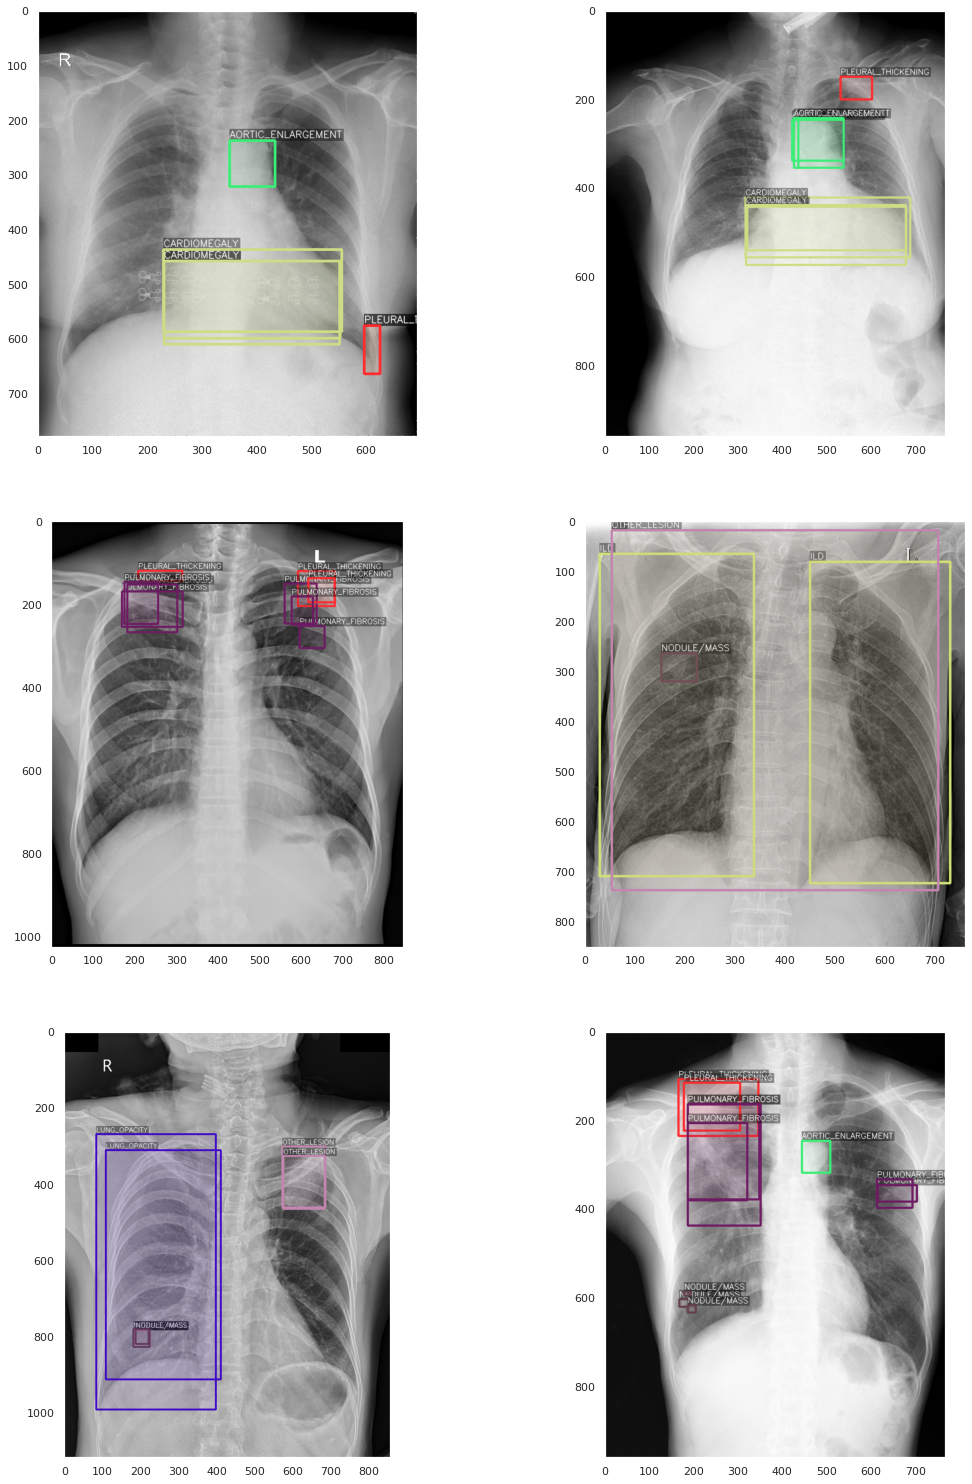

In [12]:
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]

thickness = 3
imgs = []

for img_id, path in zip(train_annotations['image_id'][:6], train_annotations['image_path'][:6]):
    boxes = train_annotations.loc[train_annotations['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
    
    img_labels = train_annotations.loc[train_annotations['image_id'] == img_id, ['class_id']].values.squeeze()
    
    img = cv2.imread(path)
    
    for label_id, box in zip(img_labels, boxes):
        color = label2color[label_id]
        img = draw_bbox(img, list(np.int_(box)), viz_labels[label_id], color)
        
    imgs.append(img)
    
plot_imgs(imgs, size = 9, cmap = None)
    
    
    

**Non-maximum Suppression (NMS)**

0it [00:00, ?it/s]

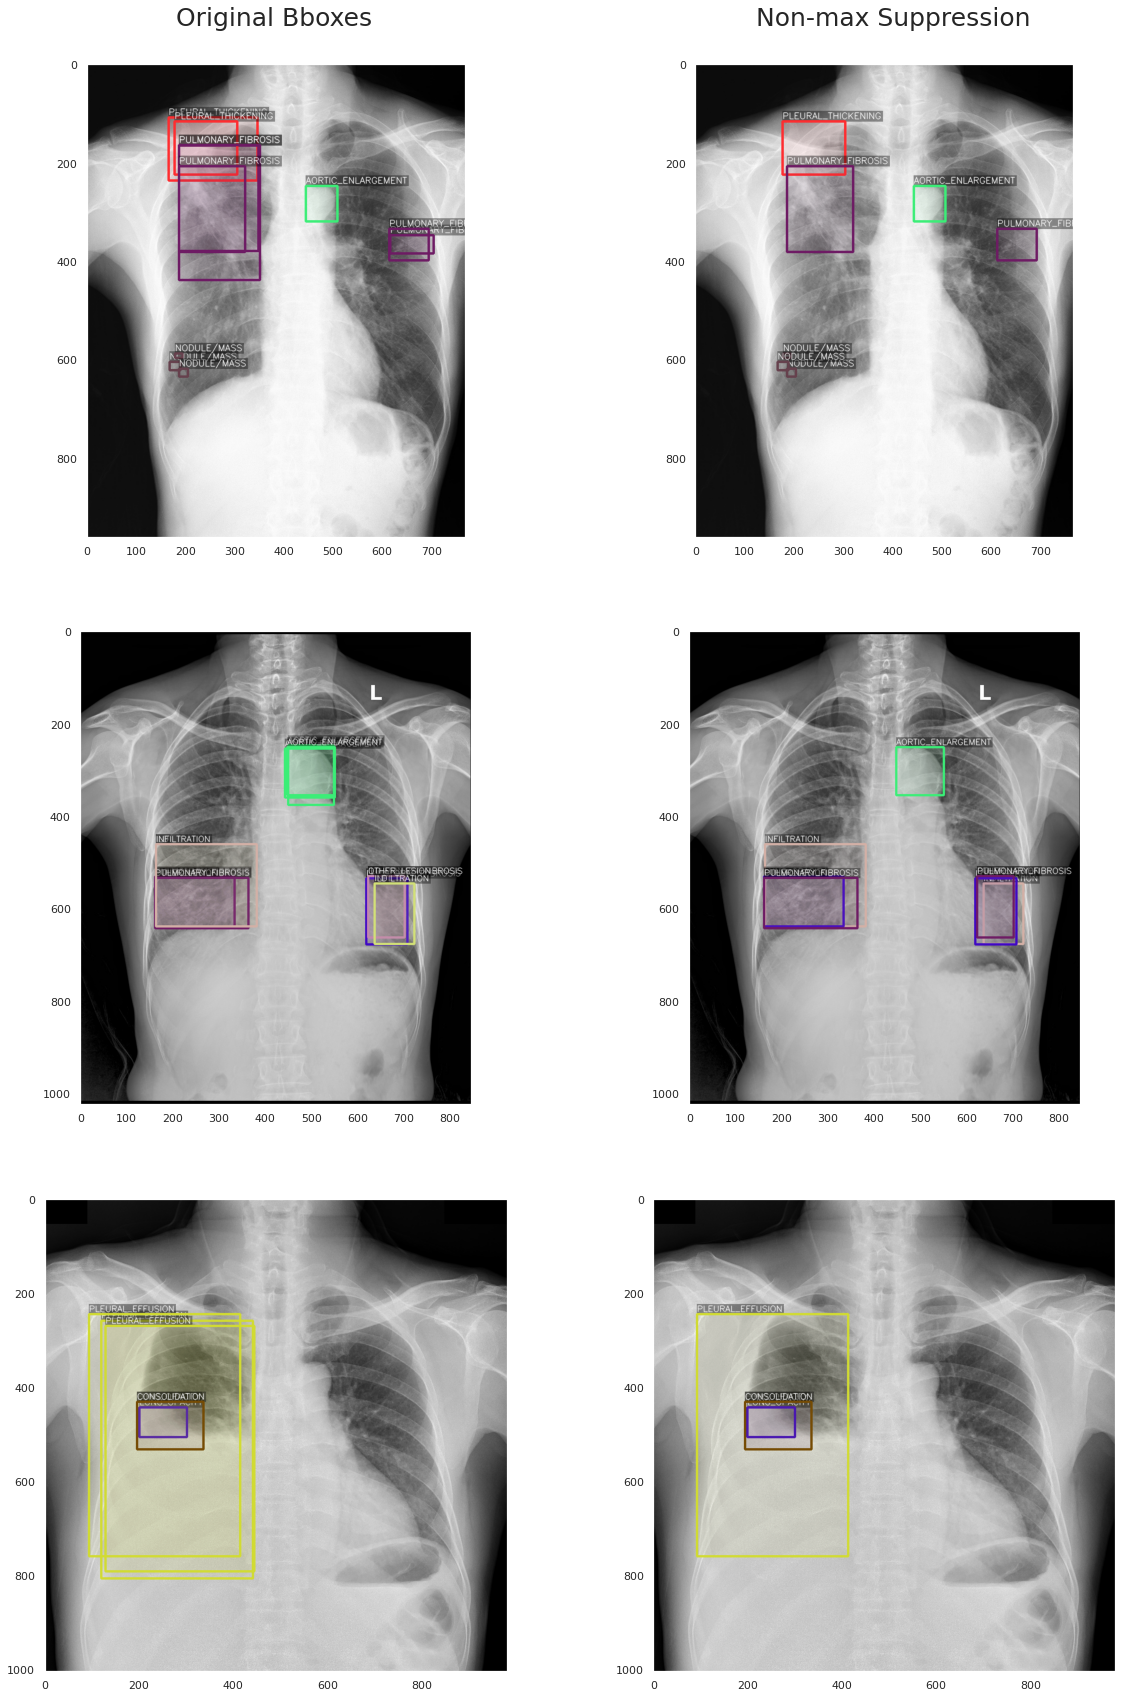

In [52]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i,path in tqdm(enumerate(imagepaths[5:8])):
    img_array = cv2.imread(path)
    image_basename = Path(path).stem
#     print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename]
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
#     print(count_dict)
    
    for cid in cls_ids:
        
        if count_dict[cid] == 1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id == cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())
            
        else:
            cls_list = img_annotations[img_annotations.class_id == cid]['class_id'].tolist()
            
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())
            

            weights.append(1)
       
    boxes, scores, box_labels = nms(boxes_list, scores_list, labels_list, weights = weights, iou_thr = iou_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Non-max Suppression", va="top", ha="center", size=25)
plt.savefig('nms.png', bbox_inches='tight')
plt.show()

0it [00:00, ?it/s]

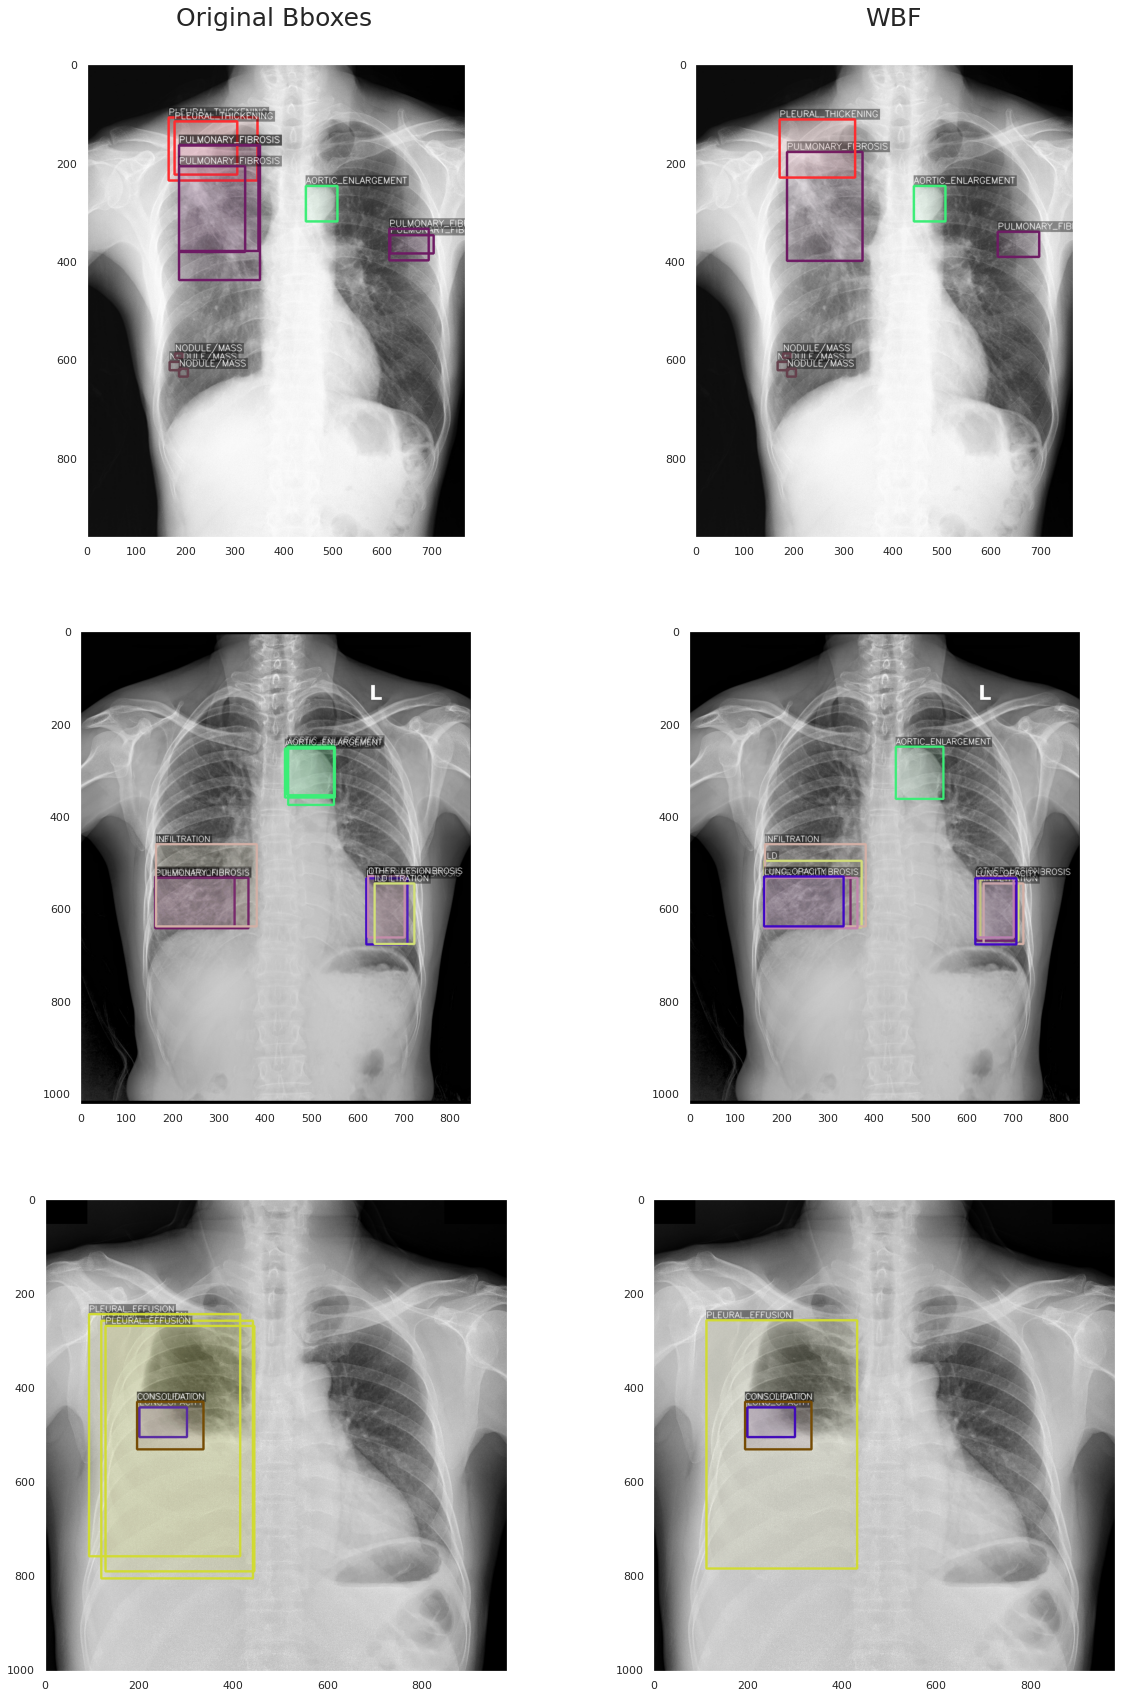

In [54]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
sigma = 0.1

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
#     print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
#     print("Bboxes before WBF:\n", boxes_viz)
#     print("Labels before WBF:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
#     print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            

    # Perform WBF
    boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
#     print("Bboxes after WBF:\n", boxes)
#     print("Labels after WBF:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
#     print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.savefig('wbf.png', bbox_inches='tight')
plt.show()